## 🍄 Project overview: mushroom classification

In this project, a machine learning pipeline was developed to classify mushrooms as edible or poisonous based on their physical characteristics. The dataset consists entirely of categorical features, requiring careful preprocessing before model training.

Missing values were identified in the `stalk-root` feature, originally encoded as `?`. Rather than removing these observations, missing values were replaced with a dedicated category (`m`) to preserve potentially informative patterns. All categorical features were then one-hot encoded using `drop_first=True` to avoid multicollinearity.

Multiple classification models were trained and evaluated, including Logistic Regression, Decision Tree, and Random Forest classifiers. Model performance was assessed using accuracy, classification reports, and confusion matrices to better understand both overall performance and error types.

While Logistic Regression achieved near-perfect accuracy, confusion matrix analysis revealed a small number of false negatives for the poisonous class. Decision Trees achieved perfect classification when unconstrained but showed underfitting when tree depth was limited. The Random Forest model achieved perfect classification on the test set and eliminated all poisonous-to-edible misclassifications, demonstrating the robustness of ensemble methods for this dataset.

Overall, the results highlight the importance of proper preprocessing, model comparison, and evaluation beyond accuracy alone, particularly in safety-critical classification tasks.

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets 
  
# metadata 
#print(mushroom.metadata) 
  
# variable information 
# print(mushroom.variables) 

In [2]:
import pandas as pd

df = pd.read_csv("mushroom_dataset.csv")
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


In [3]:
# checking the dataframe for nan values
df.isna().mean().sort_values(ascending=False)

stalk-root                  0.305268
cap-shape                   0.000000
stalk-surface-below-ring    0.000000
habitat                     0.000000
population                  0.000000
spore-print-color           0.000000
ring-type                   0.000000
ring-number                 0.000000
veil-color                  0.000000
veil-type                   0.000000
stalk-color-below-ring      0.000000
stalk-color-above-ring      0.000000
stalk-surface-above-ring    0.000000
cap-surface                 0.000000
stalk-shape                 0.000000
gill-color                  0.000000
gill-size                   0.000000
gill-spacing                0.000000
gill-attachment             0.000000
odor                        0.000000
bruises                     0.000000
cap-color                   0.000000
poisonous                   0.000000
dtype: float64

In [4]:
# total nan values for stalk-root
df["stalk-root"].isna().sum()

np.int64(2480)

In [5]:
# checking for unique value counts within stalk-root
df["stalk-root"].value_counts()

stalk-root
b    3776
e    1120
c     556
r     192
Name: count, dtype: int64

In [6]:
# replacing missing values with m
df["stalk-root"] = df["stalk-root"].fillna("m")

In [7]:
df["stalk-root"].value_counts()

stalk-root
b    3776
m    2480
e    1120
c     556
r     192
Name: count, dtype: int64

## 🧬 One-hot encoding

Before training the our models (Logistic Regressions, Decision Tree, Random Forest), we separate the input features from the target variable and convert all categorical features into a numerical format.

### Feature / target split
- The target variable `poisonous` is removed from the feature matrix `X` to prevent data leakage
- The target vector `y` contains the class label (edible vs poisonous)
- All categorical features are transformed using **one-hot encoding** via `pd.get_dummies()`
- This converts each categorical value into a binary feature indicating its presence or absence

In [8]:
X = df.drop(columns = ["poisonous"])
y = df["poisonous"]

In [9]:
import pandas as pd

X_encoded = pd.get_dummies(X, drop_first=True)

pd.set_option("display.max_columns", None)
X_encoded.head()

,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,bruises_t,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill-attachment_f,gill-spacing_w,gill-size_n,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stalk-shape_t,stalk-root_c,stalk-root_e,stalk-root_m,stalk-root_r,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-above-ring_y,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-surface-below-ring_y,stalk-color-above-ring_c,stalk-color-above-ring_e,stalk-color-above-ring_g,stalk-color-above-ring_n,stalk-color-above-ring_o,stalk-color-above-ring_p,stalk-color-above-ring_w,stalk-color-above-ring_y,stalk-color-below-ring_c,stalk-color-below-ring_e,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-color_o,veil-color_w,veil-color_y,ring-number_o,ring-number_t,ring-type_f,ring-type_l,ring-type_n,ring-type_p,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_o,spore-print-color_r,spore-print-color_u,spore-print-color_w,spore-print-color_y,population_c,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
1,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
3,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
4,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,

## Logistic Regression Model

In [10]:
y_encoded = y.map({'e': 0, 'p': 1})

In [11]:
y_encoded.value_counts()

poisonous
0    4208
1    3916
Name: count, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [14]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[842,   0],
       [  3, 780]])

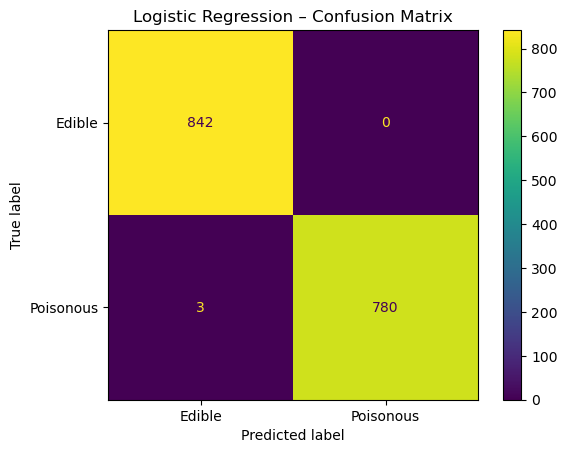

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm_lr = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=["Edible", "Poisonous"]
)

disp.plot()
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [20]:
y_pred_dt = dt_model.predict(X_test)

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [22]:
import pandas as pd

importances = dt_model.feature_importances_
features = X_encoded.columns   # must match the data used to train the tree

importance_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

importance_df.head(10)

,feature,importance
22,odor_n,0.617790
41,stalk-root_c,0.179322
44,stalk-root_r,0.085038
80,spore-print-color_r,0.035830
20,odor_l,0.021383
65,stalk-color-below-ring_w,0.015614
50,stalk-surface-below-ring_y,0.013490
81,spore-print-color_u,0.010882
18,odor_c,0.009784
75,ring-type_p,0.005331


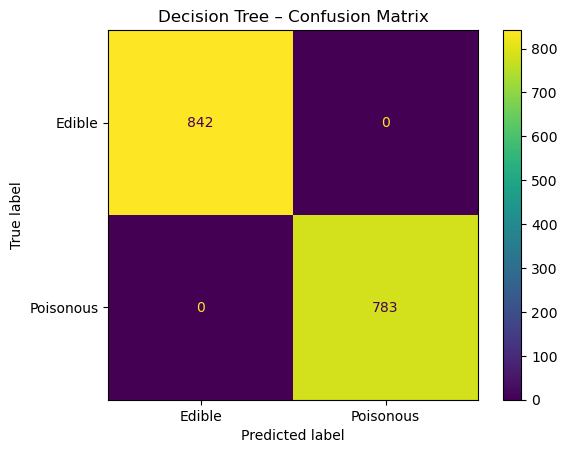

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_dt = confusion_matrix(y_test, y_pred_dt)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_dt,
    display_labels=["Edible", "Poisonous"]
)

disp.plot()
plt.title("Decision Tree – Confusion Matrix")
plt.show()

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

model.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
# predict
y_pred_rf = model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [26]:
import pandas as pd

importances = model.feature_importances_
features = X_encoded.columns   # since you encoded earlier

importance_df = pd.DataFrame({"feature": features,"importance": importances}).sort_values(by="importance", ascending=False)

importance_df.head(10)

,feature,importance
22,odor_n,0.182788
28,gill-size_n,0.087572
19,odor_f,0.077562
17,bruises_t,0.045205
45,stalk-surface-above-ring_k,0.041130
48,stalk-surface-below-ring_k,0.040399
76,spore-print-color_h,0.040074
75,ring-type_p,0.028731
87,population_v,0.027761
42,stalk-root_e,0.021765


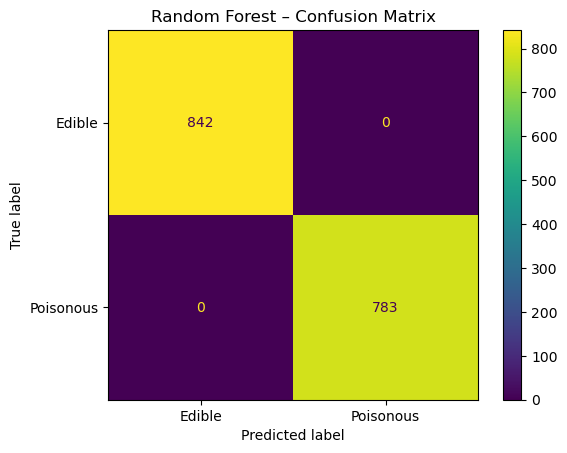

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf,
    display_labels=["Edible", "Poisonous"]
)

disp.plot()
plt.title("Random Forest – Confusion Matrix")
plt.show()

## Model Development and Hyperparameter Tuning

Initial classification models were developed using Logistic Regression, Decision Tree, and Random Forest classifiers. To improve generalization performance and avoid arbitrary model configuration, hyperparameter tuning was performed using Grid Search with 5-fold cross-validation.

For the Decision Tree, parameters controlling model complexity such as maximum depth and minimum samples per leaf were tuned. For the Random Forest, the number of estimators and tree depth were optimized. The best-performing models were selected based on cross-validation accuracy and evaluated on a held-out test set.

This process ensured that final model performance was robust and not dependent on a single train–test split.

## 🌲 Grid Search for Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# 1. Define the parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

In [29]:
# create the model
rf = RandomForestClassifier(random_state=42)

In [30]:
# create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

In [31]:
# fit the grid search on the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [32]:
# best parameters and best CV score
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy: 1.0


In [33]:
# evaluate on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)


print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



## 🌲 Grid Search for Decision Tree

In [34]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [35]:
grid_dt.best_params_

{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [36]:
best_dt = grid_dt.best_estimator_

y_pred_dt_tuned = best_dt.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_dt_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [37]:
results_dt = pd.DataFrame(grid_dt.cv_results_)

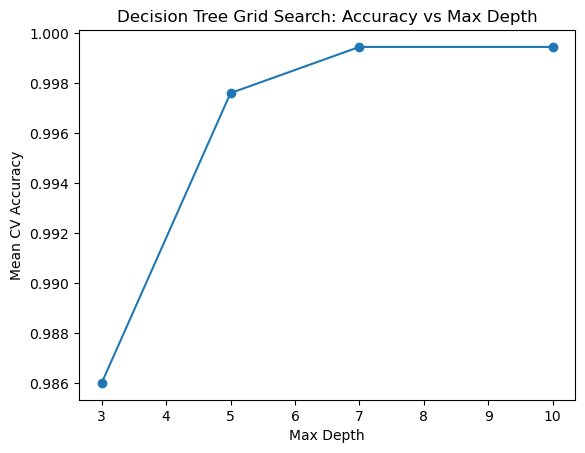

In [38]:
import matplotlib.pyplot as plt

depth_scores = (
    results_dt
    .groupby('param_max_depth')['mean_test_score']
    .mean()
)

plt.figure()
depth_scores.plot(marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Mean CV Accuracy")
plt.title("Decision Tree Grid Search: Accuracy vs Max Depth")
plt.show()

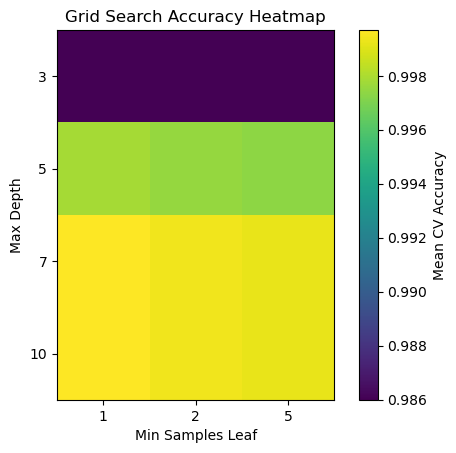

In [39]:
pivot = results_dt.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_leaf'
)

plt.figure()
plt.imshow(pivot)
plt.colorbar(label="Mean CV Accuracy")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel("Min Samples Leaf")
plt.ylabel("Max Depth")
plt.title("Grid Search Accuracy Heatmap")
plt.show()

## Decision Tree from Random Forest 🌳

- **Tree selection**  
  This visualization shows **Decision Tree #0**, the first tree in the Random Forest consisting of 100 trees.  
  While the overall prediction comes from the ensemble, individual trees can be inspected to understand how feature-based rules are learned.

- **Root split (first decision)**  
  The root node splits on **stalk-surface-above-ring_k**, indicating that this feature provides the best separation between edible and poisonous mushrooms *for this tree*.  
  Different trees in the forest may select different root features.

- **Node colors and confidence**  
  Node color represents the predicted class:
  - **Lilac** → poisonous
  - **Green** → edible 

  Color intensity reflects **prediction confidence (purity)**:
  - Strong color → high confidence  
  - Faint color → higher uncertainty

- **Gini impurity**  
  Gini impurity measures how mixed the classes are at a node:
  - **Gini = 0** → perfectly pure node  
  - Higher Gini → more mixed classes

- **Decision paths**  
  Each path from the root to a leaf represents a sequence of feature-based decisions that leads to a final edible or poisonous classification.


In [40]:
import os

# Make sure Python can find the `dot` executable from Homebrew
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

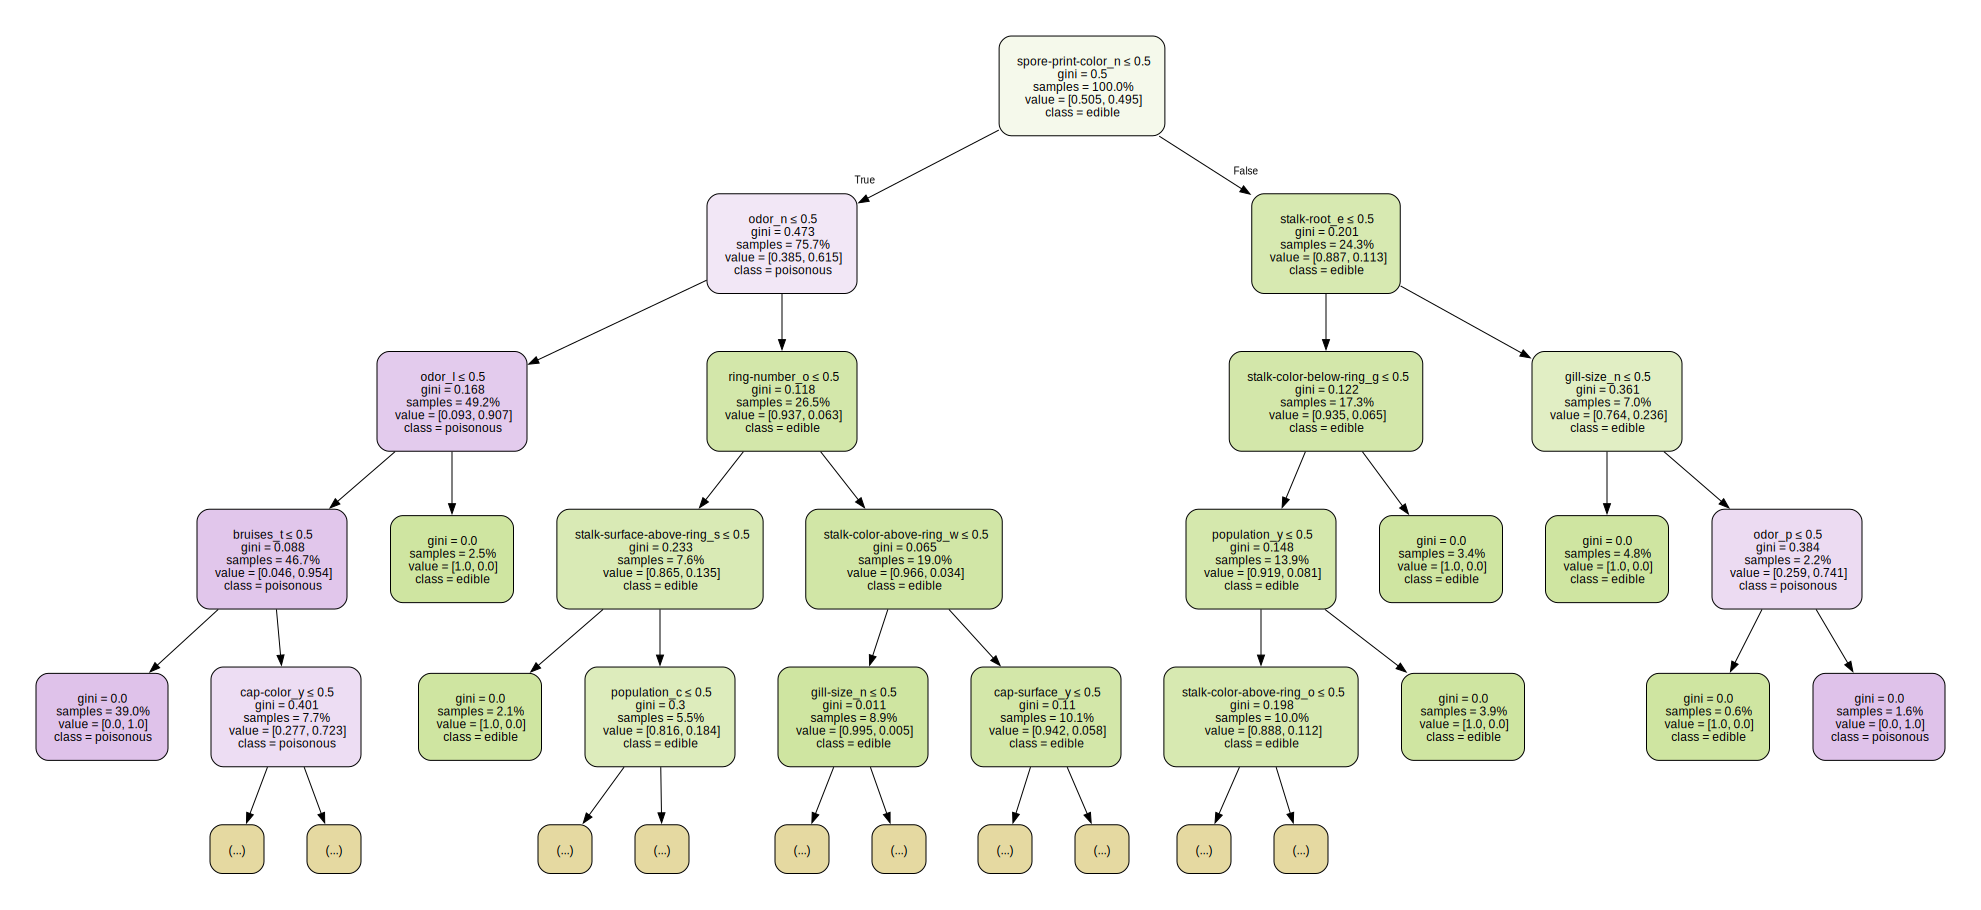

In [41]:
import re
import os
import graphviz
from sklearn.tree import export_graphviz

# pick one tree from the random forest
one_tree = best_rf.estimators_[0]

# export the tree to DOT
dot = export_graphviz(
    one_tree,
    out_file=None,
    feature_names=X_encoded.columns,
    class_names=["edible", "poisonous"],
    filled=True,
    rounded=True,
    proportion=True,
    special_characters=True,
    max_depth=4      # <--- truncate here
)

# inject transparent background + white arrows/borders
dot = dot.replace(
    "digraph Tree {",
    """digraph Tree {
graph [pad="0.5", nodesep="0.6", ranksep="0.8", bgcolor="transparent"];
node  [
    shape=box,
    style="rounded,filled",
    fontname="Helvetica",
    fontsize=12,
    margin="0.25",
];
edge  [
    fontname="Helvetica",
    fontsize=10,
];
"""
)

# custom palette + purity-based intensity
base_edible  = "#CFE5A1"   # green
base_poison  = "#DFC2EA"   # lilac
base_root   = "#E5D9A1"    # gold

white = (255, 255, 255)

def hex2rgb(h):
    h = h.lstrip("#")
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def rgb2hex(rgb):
    return "#{:02X}{:02X}{:02X}".format(*rgb)

def blend(base_hex, purity):
    """Blend base color with white based on purity."""
    base = hex2rgb(base_hex)

    # purity = 0.5 → very faint, purity = 1 → strong
    p = max(0, min(1, (purity - 0.5) / 0.5))

    # keep a small tint even at low purity
    alpha = 0.2 + 0.8 * p

    r = int(white[0] + (base[0] - white[0]) * alpha)
    g = int(white[1] + (base[1] - white[1]) * alpha)
    b = int(white[2] + (base[2] - white[2]) * alpha)
    return rgb2hex((r, g, b))

new = []
for line in dot.splitlines():
    if "label=" in line and "fillcolor=" in line:

        # choose base color by class
        if "class = edible" in line:
            base = base_edible
        elif "class = poisonous" in line:
            base = base_poison
        else:
            base = base_root

        # extract purity from "value = [x, y]"
        m = re.search(r"value = \[([0-9., ]+)\]", line)
        if m:
            vals = [float(v) for v in m.group(1).split(",")]
            total = sum(vals) or 1
            probs = [v / total for v in vals]
            purity = max(probs)
        else:
            purity = 1.0

        # compute final color
        color = blend(base, purity)

        # overwrite fillcolor
        line = re.sub(r'fillcolor="[^"]+"', f'fillcolor="{color}"', line)

    new.append(line)

dot = "\n".join(new)

# render PNG to Desktop with transparent background

desktop_path = os.path.expanduser("~/Desktop/predictive-models-project/tree_clean")
graph = graphviz.Source(dot)
graph.render(desktop_path, format="png", renderer="cairo")

graph

In [42]:
# checking which tree it is within the random forest ---> 0 = first tree
for i, tree in enumerate(best_rf.estimators_):
    if tree is one_tree:
        print("This is decision tree #", i)

This is decision tree # 0


In [43]:
#total number of trees
len(model.estimators_)

100

In [44]:
#checking thae the decision tree is from the Random Forest model
type(model)

sklearn.ensemble._forest.RandomForestClassifier